In [1]:
import sqlite3
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate

In [2]:
from python_functions import *

In [3]:
write_database('../database/logdata.db', '192.168.1.55', 60)

Timestamp: 2025-10-05T16:45:48.368148
Power consumption: 325.17 W
Power production: -164.57 W
Relay status: False
Timestamp: 2025-10-05T16:46:49.389269
Power consumption: 346.26 W
Power production: -180.15 W
Relay status: False
Logging interrupted.
SQLite connection closed.


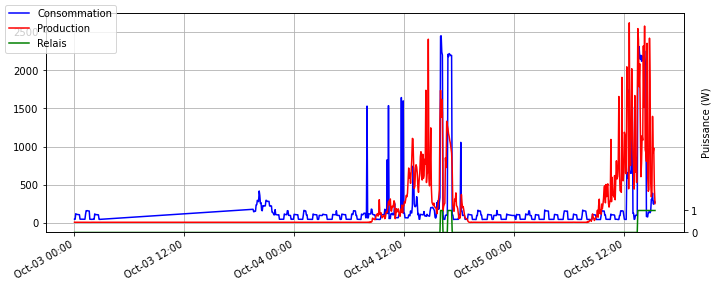

In [4]:
plot_logdata('../database/logdata.db', '../webserver/solaire_graph.png')

In [5]:
display_logdata('../database/logdata.db')

+----------------------------+----------+----------+----------+
| Date / Heure               |   Conso. |    Prod. |   Relais |
|----------------------------+----------+----------+----------|
| 2025-10-05T16:46:49.389269 |   346.26 |  -180.15 |        0 |
| 2025-10-05T16:45:48.368148 |   325.17 |  -164.57 |        0 |
| 2025-10-05T15:20:59.844030 |   281.98 |  -258.95 |        1 |
| 2025-10-05T15:19:59.736894 |   271.18 |  -253.87 |        1 |
| 2025-10-05T15:18:59.312887 |   293.44 |  -267.6  |        1 |
| 2025-10-05T15:17:59.014507 |   270.26 |  -291.63 |        1 |
| 2025-10-05T15:16:58.849444 |   289.83 |  -342.96 |        1 |
| 2025-10-05T15:15:58.738670 |   287.84 |  -447.65 |        1 |
| 2025-10-05T15:14:58.630248 |   301.97 |  -496.14 |        1 |
| 2025-10-05T15:13:58.517066 |   235.51 |  -545.7  |        1 |
| 2025-10-05T15:12:58.408550 |   239.93 |  -716.36 |        1 |
| 2025-10-05T15:11:58.260861 |   244.48 |  -981.32 |        1 |
| 2025-10-05T15:10:57.945609 |   242.72 

Entwurf

In [1]:
db_file = '../database/logdata.db'
png_file = '../webserver/solaire_graph.png'

In [66]:
conn = sqlite3.connect (db_file)
c = conn.cursor()

sql = """CREATE VIEW IF NOT EXISTS vwPlot AS
        SELECT em0.[timestamp],
                em0.[power] as 'power_0',
                em1.[power] as 'power_1',
                rel.[ison] as 'relay_state'
        FROM emeters0 AS em0
                INNER JOIN emeters1 AS em1 ON em0.[timestamp] = em1.[timestamp]
                        INNER JOIN relay AS rel ON em0.[timestamp] = rel.[timestamp]
        WHERE em0.[timestamp] >= datetime('now', '-2 day');"""
c.execute(sql)

sql = """SELECT [timestamp], [power_0], [power_1], [relay_state]
        FROM vwPlot            
        ORDER BY [timestamp]"""
c.execute(sql)
rows = c.fetchall()
conn.close()

In [67]:
rows[0:10]

[('2025-09-15T00:00:00.180598', 48.72, -8.04, 0),
 ('2025-09-15T00:01:01.027608', 48.65, -8.11, 0),
 ('2025-09-15T00:02:01.149627', 49.22, -8.09, 0),
 ('2025-09-15T00:03:01.260433', 48.66, -8.0, 0),
 ('2025-09-15T00:04:01.368259', 48.52, -7.56, 0),
 ('2025-09-15T00:05:01.478334', 48.71, -8.3, 0),
 ('2025-09-15T00:06:01.585630', 48.7, -7.55, 0),
 ('2025-09-15T00:07:01.690435', 48.7, -8.17, 0),
 ('2025-09-15T00:08:02.058345', 48.54, -7.89, 0),
 ('2025-09-15T00:09:02.251461', 49.08, -8.38, 0)]

In [29]:
# Reduction : 1 point sur 4
idx = range(0, len(rows), 4)
rows_red = [rows[i] for i in idx]

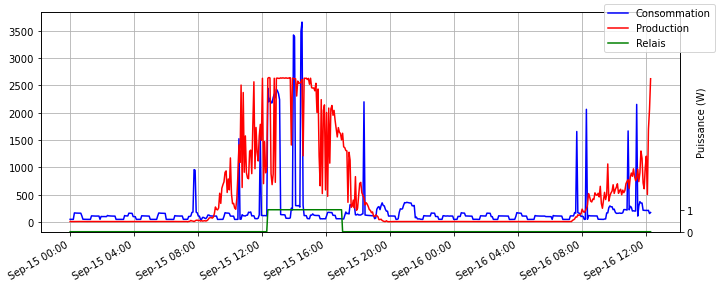

In [31]:
time = [datetime.datetime.fromisoformat(r[0]) for r in rows_red]
power_0 = [r[1] for r in rows_red]
power_1 = [-r[2] for r in rows_red]
relay_state = [r[3] for r in rows_red]

fig, ax1 = plt.subplots(figsize=(10, 4))
#fig = plt.figure(figsize=(10, 4))

ax2 = ax1.twinx()

ax1.plot(time, power_0, label='Consommation', color='b')
ax1.plot(time, power_1, label='Production', color='r')
ax2.plot(time, relay_state, label='Relais', color='g')

plt.xlabel('Date')
plt.ylabel('Puissance (W)')
plt.title('')

ax2.set_yticks([0, 1])
ax2.set_ylim([0, 10])

ax1.grid(True)

fig.legend(loc='upper right')
fig.tight_layout()

fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
plt.gcf().autofmt_xdate()
fig.savefig(png_file)

In [69]:
print(tabulate(rows[:20], headers=["Date / Heure", "Conso.", "Prod.", "Relais"], tablefmt="psql"))

+----------------------------+----------+---------+----------+
| Date / Heure               |   Conso. |   Prod. |   Relais |
|----------------------------+----------+---------+----------|
| 2025-09-15T00:00:00.180598 |    48.72 |   -8.04 |        0 |
| 2025-09-15T00:01:01.027608 |    48.65 |   -8.11 |        0 |
| 2025-09-15T00:02:01.149627 |    49.22 |   -8.09 |        0 |
| 2025-09-15T00:03:01.260433 |    48.66 |   -8    |        0 |
| 2025-09-15T00:04:01.368259 |    48.52 |   -7.56 |        0 |
| 2025-09-15T00:05:01.478334 |    48.71 |   -8.3  |        0 |
| 2025-09-15T00:06:01.585630 |    48.7  |   -7.55 |        0 |
| 2025-09-15T00:07:01.690435 |    48.7  |   -8.17 |        0 |
| 2025-09-15T00:08:02.058345 |    48.54 |   -7.89 |        0 |
| 2025-09-15T00:09:02.251461 |    49.08 |   -8.38 |        0 |
| 2025-09-15T00:10:02.404938 |    48.3  |   -8.2  |        0 |
| 2025-09-15T00:11:02.512092 |    48.26 |   -8.12 |        0 |
| 2025-09-15T00:12:02.624155 |    48.03 |   -8.33 |    